#  About the Author

**👤 Name:** Muhammad Umer  
**🔗 LinkedIn:** [https://www.linkedin.com/in/therealumerhayat/](https://www.linkedin.com/in/therealumerhayat/)  
**📧 Gmail:** umerhayat282@gmail.com  
**📞 Contact Number:** +92 302 9854427 / +92 317 6239577

****

#   1. Problem Statement and Business Case

In today's digital age, the rapid spread of information through online platforms and social media has made it increasingly difficult to distinguish between credible news and misleading or false content. The rise of misinformation and fake news poses serious threats to public trust, informed decision-making, and even democratic processes.

This project aims to develop a machine learning model capable of detecting fake news using Recurrent Neural Networks (RNNs), a type of deep learning architecture well-suited for understanding sequential and textual data. By analyzing the linguistic patterns and context of news articles, our model seeks to identify whether a given article is genuine or deceptive.

The core objectives of this project are:

To clean and preprocess news text data

To build and train an RNN model (e.g., using LSTM or GRU)

To evaluate the model's accuracy in classifying fake versus real news

To contribute to the broader fight against misinformation by providing an automated tool for early detection

This solution has real-world applications in journalism, content moderation, and fact-checking systems, ultimately promoting a healthier and more informed digital environment.

#   2. Import liabraries and the dataset.

In [43]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, Bidirectional, MaxPool1D
from tensorflow.keras.models import Model
from jupyterthemes import jtplot
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import nltk
nltk.download('punkt')
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

from sklearn.metrics import confusion_matrix


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#import dataset
true_df = pd.read_csv("/kaggle/input/fake-news/True.csv")
fake_df = pd.read_csv("/kaggle/input/fake-news/Fake.csv")

In [5]:
print(f"Number of data sample in True Class: {len(true_df)}")
print(f"Number of data sample in Fake Class: {len(fake_df)}")

print(f"%age of Null values in True Class: {true_df.isnull().sum().sum()}")
print(f"%age of Null values in Fake Class: {fake_df.isnull().sum().sum()}")

Number of data sample in True Class: 21417
Number of data sample in Fake Class: 23481
%age of Null values in True Class: 0
%age of Null values in Fake Class: 0


#   2. Exploratory Data Analysis

In [6]:
true_df['is_fake'] = 1 
fake_df['is_fake'] = 0

df = pd.concat([true_df, fake_df]).reset_index(drop=True)
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  is_fake  
0  December 31, 2017         1  
1  December 29, 2017         1  
2  December 31, 2017         1  
3  December 30, 2017         1  
4  December 29, 2017         1

In [7]:
df.drop(columns = 'date', inplace=True)

In [8]:
#combine title and text together
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  is_fake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews        1   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews        1   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews        1   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews        1   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

In [9]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

#   4. Data Cleaning

In [10]:
#download stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
#get extra stopwords from nltk
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [12]:
#removing stop words that has two words or less words
def preprocessing(text):
    results = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3 and token not in stop_words:
            results.append(token)
    return results

In [13]:
df['clean'] = df['original'].apply(preprocessing)

In [14]:
df['original'][0]

'As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non

In [15]:
df['clean'][0]

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [16]:
df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

       is_fake                                           original  \
0            1  As U.S. budget fight looms, Republicans flip t...   
1            1  U.S. military to accept transgender recruits o...   
2            1  Senior U.S. Republican senator: 'Let Mr. Muell...   
3            1  FBI Russia probe helped by Australian diplomat...   
4            1  Trump wants Postal Service to charge 'much mor...   
...        ...                                                ...   
44893        0  McPain: John McCain Furious That Iran Treated ...   
44894        0  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895        0  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896        0  How to Blow $700 Million: Al Jazeera America F...   
44897        0  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                   clean  
0      [budget, fight, looms, republicans, flip, fisc...  
1      [military, accept, transgender, recruits, mond...  
2      [senior, republican, senator, mueller, washing...  
3      [russia, probe, helped, australian, diplomat, ...  
4      [trump, wants, postal, service, charge, amazon...  
...                                                  ...  
44893  [mcpain, john, mccain, furious, iran, treated,...  
44894  [justice, yahoo, settles, mail, privacy, class...  
44895  [sunnistan, allied, safe, zone, plan, territor...  
44896  [blow, million, jazeera, america, finally, cal...  
44897  [navy, sailors, held, iranian, military, signs...  

[44898 rows x 6 columns]

In [17]:
#get the list of the words
list_of_words = []
for i in df.clean:
    for j in i:
        list_of_words.append(j)

In [18]:
list_of_words

['budget',
 'fight',
 'looms',
 'republicans',
 'flip',
 'fiscal',
 'script',
 'washington',
 'reuters',
 'head',
 'conservative',
 'republican',
 'faction',
 'congress',
 'voted',
 'month',
 'huge',
 'expansion',
 'national',
 'debt',
 'cuts',
 'called',
 'fiscal',
 'conservative',
 'sunday',
 'urged',
 'budget',
 'restraint',
 'keeping',
 'sharp',
 'pivot',
 'republicans',
 'representative',
 'mark',
 'meadows',
 'speaking',
 'face',
 'nation',
 'drew',
 'hard',
 'line',
 'federal',
 'spending',
 'lawmakers',
 'bracing',
 'battle',
 'january',
 'return',
 'holidays',
 'wednesday',
 'lawmakers',
 'begin',
 'trying',
 'pass',
 'federal',
 'budget',
 'fight',
 'likely',
 'linked',
 'issues',
 'immigration',
 'policy',
 'november',
 'congressional',
 'election',
 'campaigns',
 'approach',
 'republicans',
 'seek',
 'control',
 'congress',
 'president',
 'donald',
 'trump',
 'republicans',
 'want',
 'budget',
 'increase',
 'military',
 'spending',
 'democrats',
 'want',
 'proportional',
 '

In [19]:
len(list_of_words)

9276947

In [20]:
#unique words
total_words = len(list(set(list_of_words)))
total_words

108704

In [21]:
df['clean_joined'] = df['clean'].apply(lambda x: " ".join(x))
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  is_fake  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews        1   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews        1   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews        1   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews        1   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews        1   

                                            original  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                               clean  \
0  [budget, fight, looms, republicans, flip, fisc...   
1  [military, accept, transgender, recruits, mond...   
2  [senior, republican, senator, mueller, washing...   
3  [russia, probe, helped, australian, diplomat, ...   
4  [trump, wants, postal, service, charge, amazon...   

                                        clean_joined  
0  budget fight looms republicans flip fiscal scr...  
1  military accept transgender recruits monday pe...  
2  senior republican senator mueller washington r...  
3  russia probe helped australian diplomat washin...  
4  trump wants postal service charge amazon shipm...

#   5. Visualize dataset

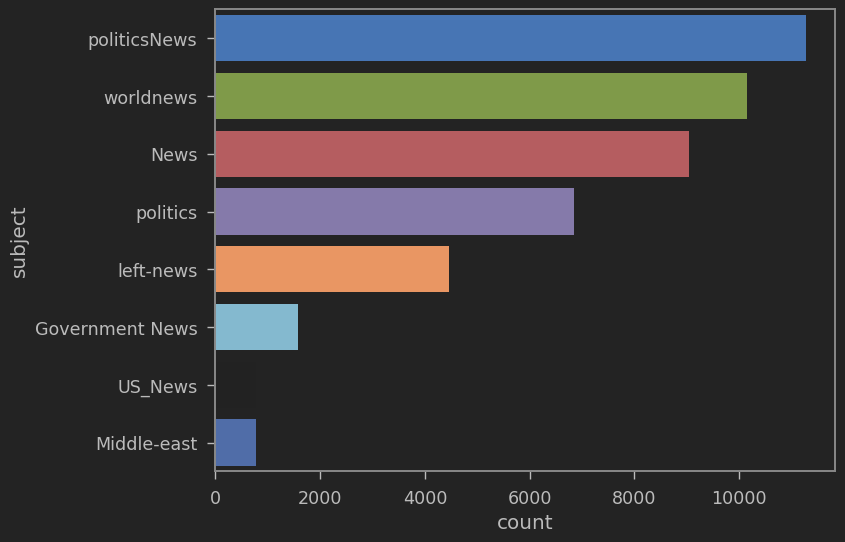

In [22]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, y='subject', order=df['subject'].value_counts().index)
plt.xlabel('count')
plt.ylabel('subject')
plt.show()

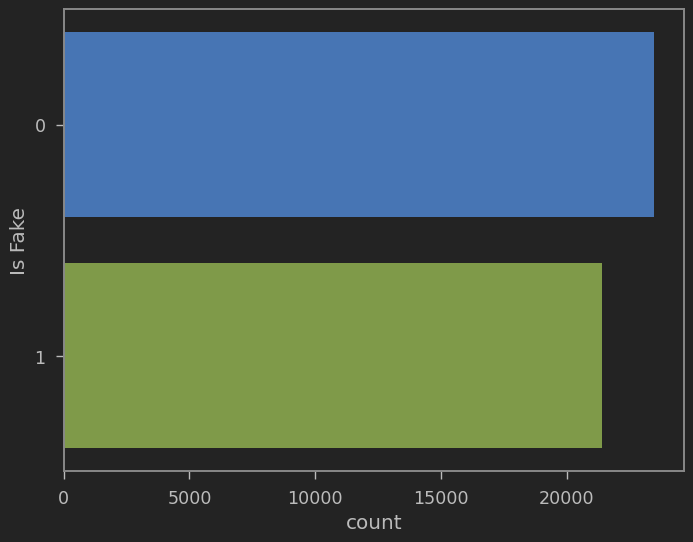

In [23]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, y='is_fake', order=df['is_fake'].value_counts().index)
plt.xlabel('count')
plt.ylabel('Is Fake')
plt.show()

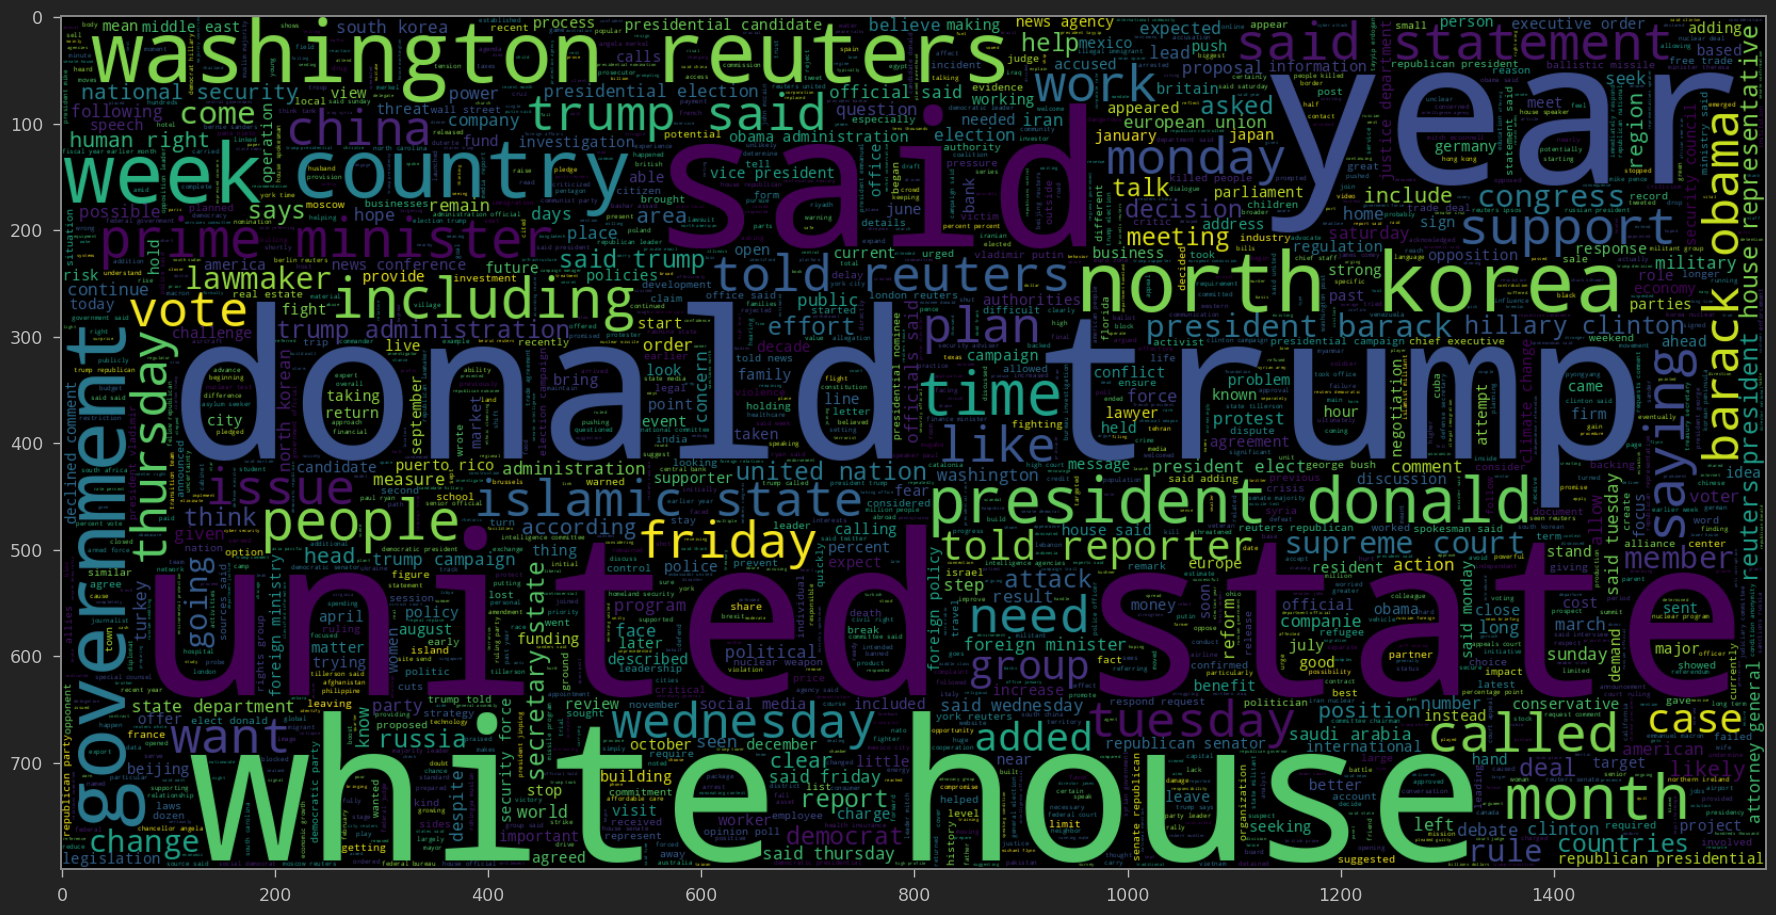

In [24]:
#plot the word cloud
plt.figure(figsize= (22,22))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop_words).generate(" ".join(df[df.is_fake == 1].clean_joined))
plt.imshow(wc, interpolation = 'bilinear') 

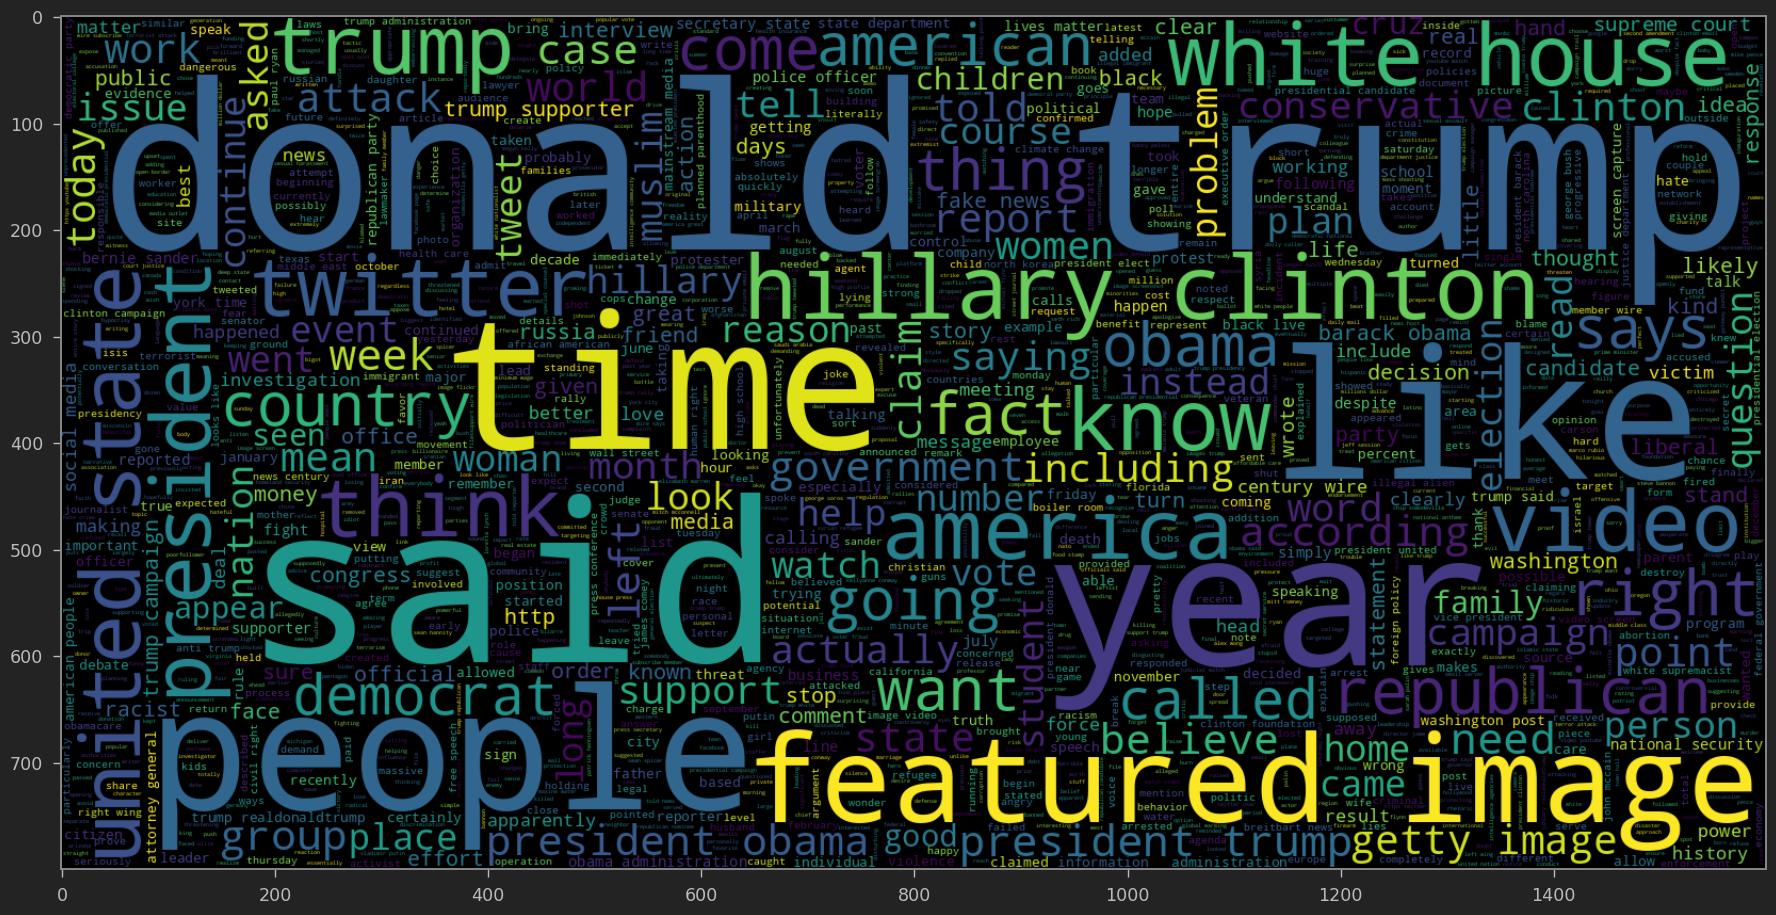

In [25]:
plt.figure(figsize= (22,22))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = stop_words).generate(" ".join(df[df.is_fake == 0].clean_joined))
plt.imshow(wc, interpolation = 'bilinear') 

In [26]:
maxlen = -1
for doc in df['clean_joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 4405


#  6. Prepare the Dataset by performing tokenization and padding

In [29]:
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.is_fake, test_size = 0.2)

In [30]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)


In [31]:
print("The encoding for document\n",df.clean_joined[0],"\n is : ",train_sequences[0])

The encoding for document
 budget fight looms republicans flip fiscal script washington reuters head conservative republican faction congress voted month huge expansion national debt cuts called fiscal conservative sunday urged budget restraint keeping sharp pivot republicans representative mark meadows speaking face nation drew hard line federal spending lawmakers bracing battle january return holidays wednesday lawmakers begin trying pass federal budget fight likely linked issues immigration policy november congressional election campaigns approach republicans seek control congress president donald trump republicans want budget increase military spending democrats want proportional increases defense discretionary spending programs support education scientific research infrastructure public health environmental protection trump administration willing going increase defense discretionary spending percent meadows chairman small influential house freedom caucus said program democrats say

In [32]:
# Add padding can either be maxlen = 4406 or smaller number maxlen = 40 seems to work well based on results
padded_train = pad_sequences(train_sequences,maxlen = 40, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences,maxlen = 40, truncating = 'post') 

In [33]:
for i,doc in enumerate(padded_train[:2]):
     print("The padded encoding for document",i+1," is : ",doc)

The padded encoding for document 1  is :  [4905   47  190    1 2319  749    9   20   10    1   17   12    3   78
 2319  229  255  229  460    3 1491 4905    2   79  300 2319  819 4752
 5467  449    3 4905    2  457  801  830  327    3   17   12]
The padded encoding for document 2  is :  [    1  2993     6  1060   351   215  1357   107    25     9     3    10
     1  2993  3458     6  1060  1011   215  1357   662   324    52    25
   126   135  1073  3979   335  1753  1357  1357 14978    63  1722  3178
  1211  2665 10294    64]


#  7. Build and train model

In [34]:
model = Sequential()
model.add(Embedding(total_words, output_dim = 128))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

2025-05-11 12:52:40.369866: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [35]:
total_words

108704

In [36]:
y_train = np.asarray(y_train)

In [37]:
model.fit(padded_train, y_train, batch_size = 64, validation_split = 0.1, epochs = 2)

Epoch 1/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 119s 219ms/step - acc: 0.9464 - loss: 0.1076 - val_acc: 0.9964 - val_loss: 0.0129
Epoch 2/2
506/506 ━━━━━━━━━━━━━━━━━━━━ 111s 220ms/step - acc: 0.9998 - loss: 0.0013 - val_acc: 0.9967 - val_loss: 0.0158


#  8. Checking the performance of Model

In [38]:
pred = model.predict(padded_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


In [41]:
prediction = []
for i in range(len(pred)):
    if pred[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)

In [42]:
accuracy = accuracy_score(list(y_test), prediction)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.9984409799554566


<Axes: >

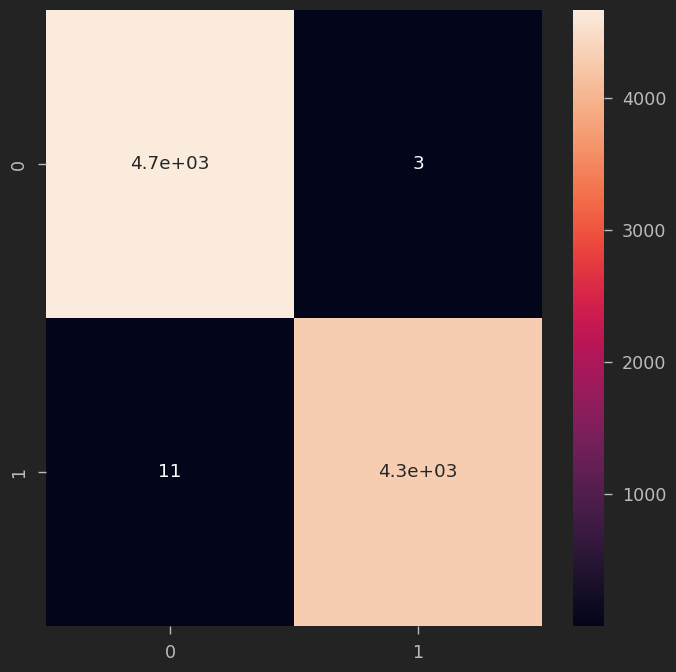

In [46]:
plt.figure(figsize = (8,8))
cm = confusion_matrix(list(y_test), prediction)
sns.heatmap(cm, annot=True)

In [47]:
category = { 0: 'Fake News', 1 : "Real News"}

In [49]:
model.save('model.keras')

In [50]:
model.save("model_weights.h5")